# Predicting Churn at QWE Inc.

* Is Wall's belief about the dependence of churn rates on customer age supported by the data? To get some intuition, try visualizing this dependence


* To start, run a single logistic regression model that best predicts the probability that a customer leaves


* What factors contribute the most to the predicted probability that these customers will leave?


* Any other better models?


* What is the predicted probability of churning for customers 672, 354, 5203? Who are the top 100 customers with highest churn probabilites?

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,10

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#All Import statements
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_curve, auc,r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression
import sklearn.model_selection
import sklearn.tree
from sklearn.tree import export_graphviz
from sklearn import svm
import sklearn.ensemble
from imblearn.over_sampling import SMOTE
import graphviz
from sklearn import svm
import sklearn.model_selection
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#df = pd.read_excel('QWE.xlsx', "Case Data")
#df.shape
import io
from google.colab import files
uploaded = files.upload()
df = pd.read_excel(io.BytesIO(uploaded.get('QWE.xlsx')), "Case Data")
df.shape

Saving QWE.xlsx to QWE.xlsx


(6347, 13)

---- QUESTION-1 -----

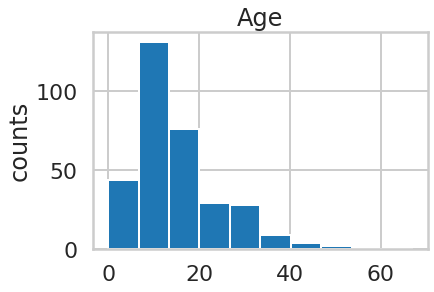

In [4]:
#you can use a weighted histogram
#Plotting the counts of Age
df.columns = ["ID","Age","Churn","CHI_0","CHI_1","Support_Cases_0","Support_Cases_1","SP_0","SP_1","Logins_1","Blogs_1", "Views_1","Days_Last_Login"]
df.hist("Age", weights=df.Churn)
plt.ylabel("counts")
plt.show()


In [5]:
#Counting the counts of unique elements in Churn
df.Churn.value_counts()

0    6024
1     323
Name: Churn, dtype: int64

Text(0, 0.5, 'Frequency of Churn')

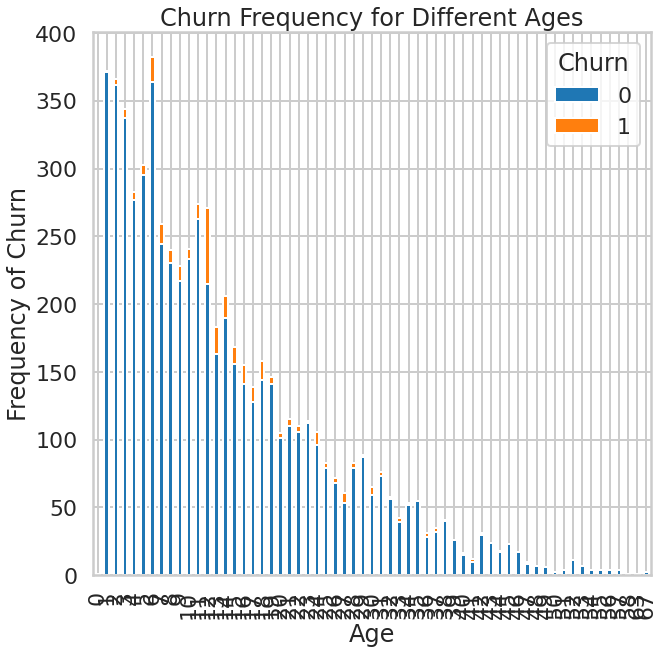

In [6]:
#Plotting the Churn Frequency by Age
pd.crosstab(df.Age, df.Churn).plot(kind='bar', stacked = True, figsize=(10,10))
plt.title('Churn Frequency for Different Ages')
plt.xlabel('Age')
plt.ylabel('Frequency of Churn')


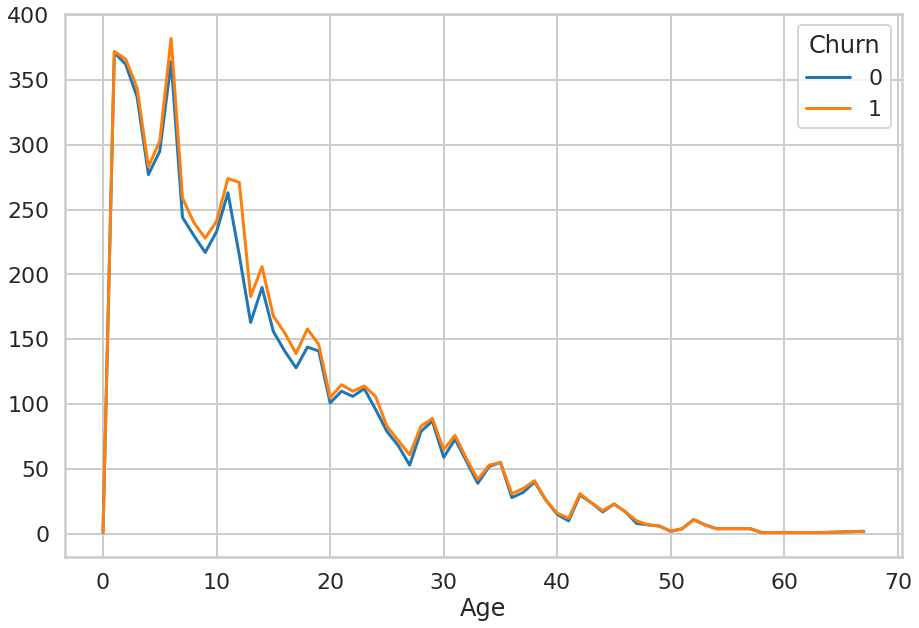

In [7]:
# Plot to check relationship between "Churn" and "Age"
pd.crosstab(df.Age, df.Churn).plot(kind='line', stacked = True, figsize=(15,10))

Wall's belief about the relation of churn rate based on age is accurate. According to the visual above, there is a high density of churning customers (compared to non-churning customers) focused around the age range of 6 months to 18 months. Throughout the rest of the line plot, there is minimal deviation between the lines of churning and non-churning customers.


In [8]:
#Calculating mean of different attributes grouped by Churn
df.groupby("Churn").mean()

,ID,Age,CHI_0,CHI_1,Support_Cases_0,Support_Cases_1,SP_0,SP_1,Logins_1,Blogs_1,Views_1,Days_Last_Login
Churn,,,,,,,,,,,,
0,3219.269588,13.818725,88.605910,5.530212,0.724270,-0.009296,0.829576,0.032682,16.138944,0.171149,106.609562,1.511454
1,2329.715170,15.352941,63.272446,-3.736842,0.371517,0.037152,0.499558,-0.016696,8.061920,-0.102167,-95.767802,6.486068


QUESTION-2 

In [9]:
# statsmodels works nicely with pandas dataframes, import the logistic regression function
import statsmodels.api as sm
from statsmodels.formula.api import logit, glm, ols

In [10]:
#Creation of training and testing sets taking into account the inbalance of the original data set 
X = df[["Age","CHI_0","CHI_1" ,"Support_Cases_0" ,"Support_Cases_1" ,"SP_0" ,"SP_1" ,"Logins_1" , "Blogs_1", "Views_1", "Days_Last_Login"]]
Y = df["Churn"]
X_train,X_test,y_train,y_test = train_test_split(X, Y, test_size = 0.30, random_state = 1)

In [11]:
#Logistic regression for all attributes in the data set without data split
lg_rg = logit('Churn ~ Age+CHI_0+CHI_1+Support_Cases_0+Support_Cases_1+SP_0+SP_1+Logins_1+Blogs_1+Views_1+Days_Last_Login',df).fit()
lg_rg.summary()

Optimization terminated successfully.
         Current function value: 0.192243
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 6347
Model:                          Logit   Df Residuals:                     6335
Method:                           MLE   Df Model:                           11
Date:                Fri, 12 Nov 2021   Pseudo R-squ.:                 0.04418
Time:                        02:16:23   Log-Likelihood:                -1220.2
converged:                       True   LL-Null:                       -1276.6
Covariance Type:            nonrobust   LLR p-value:                 5.077e-19
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.7627      0.107    -25.841      0.000      -2.972      -2.553
Age                 0.0127      0.005      2.366      0.018       0.002       0.023
CHI_0              -0.0047      0.001     -3.808      0.000      -0.007      -0.002
CHI_1              -0.0103      0.002     -4.153      0.000      -0.015      -0.005
Support_Cases_0    -0.1524      0.105     -1.452      0.146      -0.358       0.053
Support_Cases_1     0.1703      0.090      1.881      0.060      -0.007       0.348
SP_0                0.0159      0.102      0.156      0.876      -0.184       0.216
SP_1               -0.0519      0.079     -0.661      0.508      -0.206       0.102
Logins_1            0.0003      0.002      0.138      0.890      -0.004       0.004
Blogs_1             0.0003      0.020      0.015      0.988      -0.038       0.039
Views_1            -0.0001   4.07e-05     -2.697      0.007      -0.000      -3e-05
Days_Last_Login     0.0172      0.004      4.020      0.000       0.009       0.026
===================================================================================
"""

In [12]:
#Logistic regression for all attributes in the data set with data split
dftrial = pd.concat([X_train,y_train],axis=1)
print((dftrial.shape))
lg_rg = logit('Churn ~ Age+CHI_0+CHI_1+Support_Cases_0+Support_Cases_1+SP_0+SP_1+Logins_1+Blogs_1+Views_1+Days_Last_Login',dftrial).fit()
lg_rg.summary()

(4442, 12)
Optimization terminated successfully.
         Current function value: 0.186794
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4442
Model:                          Logit   Df Residuals:                     4430
Method:                           MLE   Df Model:                           11
Date:                Fri, 12 Nov 2021   Pseudo R-squ.:                 0.04267
Time:                        02:16:25   Log-Likelihood:                -829.74
converged:                       True   LL-Null:                       -866.73
Covariance Type:            nonrobust   LLR p-value:                 2.132e-11
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.9152      0.134    -21.714      0.000      -3.178      -2.652
Age                 0.0126      0.007      1.916      0.055      -0.000       0.025
CHI_0              -0.0041      0.001     -2.757      0.006      -0.007      -0.001
CHI_1              -0.0106      0.003     -3.557      0.000      -0.016      -0.005
Support_Cases_0    -0.0780      0.101     -0.770      0.441      -0.277       0.121
Support_Cases_1     0.1250      0.090      1.388      0.165      -0.052       0.302
SP_0                0.0342      0.115      0.299      0.765      -0.190       0.259
SP_1               -0.0840      0.087     -0.966      0.334      -0.254       0.086
Logins_1            0.0003      0.002      0.132      0.895      -0.004       0.005
Blogs_1             0.0029      0.023      0.128      0.898      -0.042       0.048
Views_1         -9.991e-05   4.28e-05     -2.334      0.020      -0.000    -1.6e-05
Days_Last_Login     0.0222      0.005      4.039      0.000       0.011       0.033
===================================================================================
"""

QUESTION 3

Based on the results of our logistic regression analysis, we found that five factors were significant in predicting churn for QWE. These factors were identified based on their significance value: Age, Customer Happiness Index (start and finish), Views, and Days since Last Login. So, Aggrawal must focus on these 5 attributes which help predict the customer churn to a larger extent.

In [13]:
#Logistic regression for top 5 attributes 
lg_rg_1 = logit('Churn ~ Age+CHI_0+CHI_1+Views_1+Days_Last_Login',df).fit()
lg_rg_1.summary()

Optimization terminated successfully.
         Current function value: 0.192801
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 6347
Model:                          Logit   Df Residuals:                     6341
Method:                           MLE   Df Model:                            5
Date:                Fri, 12 Nov 2021   Pseudo R-squ.:                 0.04140
Time:                        02:16:27   Log-Likelihood:                -1223.7
converged:                       True   LL-Null:                       -1276.6
Covariance Type:            nonrobust   LLR p-value:                 3.316e-21
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.7849      0.105    -26.487      0.000      -2.991      -2.579
Age                 0.0149      0.005      2.876      0.004       0.005       0.025
CHI_0              -0.0056      0.001     -5.211      0.000      -0.008      -0.003
CHI_1              -0.0094      0.002     -4.189      0.000      -0.014      -0.005
Views_1            -0.0001   4.01e-05     -2.829      0.005      -0.000   -3.48e-05
Days_Last_Login     0.0171      0.004      4.001      0.000       0.009       0.025
===================================================================================
"""

QUESTION-4
Evaluation of different models

In [14]:
#ada = ADASYN(random_state = 1)
#sampler = RandomOverSampler(sampling_strategy = 0.85, random_state = 1)
smote = SMOTE(random_state = 1)
X1, y1 = smote.fit_resample(X_train, y_train)
X2 = pd.DataFrame(X1, columns=X_train.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [15]:
#Log reg with Sklearn
log = LogisticRegression()
log.fit(X2,y1)
pred_lg = log.predict(X_test)
print(confusion_matrix(y_test, pred_lg))
print(classification_report(y_test, log.predict(X_test)))
score_log = sklearn.model_selection.cross_val_score(log, X2, y1, cv=10)
print(score_log)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[987 812]
 [ 43  63]]
              precision    recall  f1-score   support

           0       0.96      0.55      0.70      1799
           1       0.07      0.59      0.13       106

    accuracy                           0.55      1905
   macro avg       0.52      0.57      0.41      1905
weighted avg       0.91      0.55      0.67      1905



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[0.60473373 0.56568047 0.59289941 0.60118343 0.57159763 0.58106509
 0.57514793 0.59053254 0.56094675 0.55857988]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [16]:
#ROC for log
probs_log = log.predict_proba(X_test)
preds_log = probs_log[:,1]
fpr_log, tpr_log, threshold_log = roc_curve(y_test, preds_log)
roc_auc_log = auc(fpr_log, tpr_log)

In [17]:
#Creation of the XG Boost Classification Model with its cross validation score, classification report and confusion matrix 
model = XGBClassifier()
model.fit(X2, y1)

print(confusion_matrix(y_test, model.predict(X_test)))
print(f1_score(y_test, model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))
score_XGB = sklearn.model_selection.cross_val_score(model, X2, y1, cv=10)
print(score_XGB)

[[1586  213]
 [  69   37]]
0.20786516853932582
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1799
           1       0.15      0.35      0.21       106

    accuracy                           0.85      1905
   macro avg       0.55      0.62      0.56      1905
weighted avg       0.91      0.85      0.88      1905

[0.81065089 0.90532544 0.90650888 0.91005917 0.91360947 0.9147929
 0.92662722 0.91952663 0.9183432  0.9183432 ]


In [18]:
#ROC for XGboost
probs_model = model.predict_proba(X_test)
preds_model = probs_model[:,1]
fpr_model, tpr_model, threshold_model= roc_curve(y_test, preds_log)
roc_auc_model = auc(fpr_model, tpr_model)

In [19]:
model.feature_importances_

array([0.12202632, 0.10123557, 0.04111094, 0.1095907 , 0.03443144,
       0.17647348, 0.1406125 , 0.04924713, 0.06666575, 0.03103321,
       0.12757288], dtype=float32)

In [20]:
#Creation of the Naive Bayes Classification Model 
classifier = GaussianNB()
classifier.fit(X2, y1)
y_pred = classifier.predict(X_test)

In [21]:
#Calculation of our Naive Bayes Model cross validation score, classification report and confusion matrix
NB_cm = confusion_matrix(y_test, y_pred)
NB_report = classification_report(y_test, y_pred)
NB_Cross = sklearn.model_selection.cross_val_score(GaussianNB(), X2, y1, cv=10)
print(NB_cm)
print(NB_report)
print(NB_Cross)

[[ 605 1194]
 [  16   90]]
              precision    recall  f1-score   support

           0       0.97      0.34      0.50      1799
           1       0.07      0.85      0.13       106

    accuracy                           0.36      1905
   macro avg       0.52      0.59      0.31      1905
weighted avg       0.92      0.36      0.48      1905

[0.59053254 0.6        0.61301775 0.61420118 0.57751479 0.62485207
 0.60236686 0.63195266 0.5964497  0.59171598]


In [22]:
probs_nb = classifier.predict_proba(X_test)
preds_nb = probs_nb[:,1]
fpr_nb, tpr_nb, threshold_nb = roc_curve(y_test, preds_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

In [23]:
#Creation of the Decision Tree Classification Model with its cross validation score, classification report and confusion matrix 
decisionTree = sklearn.tree.DecisionTreeClassifier()
decisionTree.fit(X2, y1)
print(confusion_matrix(y_test, decisionTree.predict(X_test)))
print(classification_report(y_test, decisionTree.predict(X_test)))
score_tree = sklearn.model_selection.cross_val_score(decisionTree, X2, y1, cv=10)
print(score_tree)

[[1647  152]
 [  82   24]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1799
           1       0.14      0.23      0.17       106

    accuracy                           0.88      1905
   macro avg       0.54      0.57      0.55      1905
weighted avg       0.91      0.88      0.89      1905

[0.82485207 0.92662722 0.94201183 0.93609467 0.93609467 0.92189349
 0.93727811 0.93491124 0.93372781 0.93727811]


In [24]:
#ROC for Tree
probs_tree = decisionTree.predict_proba(X_test)
preds_tree = probs_tree[:,1]
fpr_tree, tpr_tree, threshold_tree = roc_curve(y_test, preds_tree)
roc_auc_tree = auc(fpr_tree, tpr_tree)

In [25]:
decisionTree.feature_importances_

array([0.24427079, 0.15116066, 0.08204639, 0.06296748, 0.01710838,
       0.08101038, 0.11659605, 0.05313767, 0.05237318, 0.07822759,
       0.06110144])

In [26]:
#Creation of the Bagging Classification Model with its cross validation score, classification report and confusion matrix 
bagging = sklearn.ensemble.BaggingClassifier(n_estimators=100)
bagging.fit(X2,y1)
print(confusion_matrix(y_test, bagging.predict(X_test)))
print(classification_report(y_test, bagging.predict(X_test)))
score_bagging = sklearn.model_selection.cross_val_score(bagging, X2, y1, cv=10)
print(score_bagging)

[[1717   82]
 [  89   17]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1799
           1       0.17      0.16      0.17       106

    accuracy                           0.91      1905
   macro avg       0.56      0.56      0.56      1905
weighted avg       0.91      0.91      0.91      1905

[0.87928994 0.95857988 0.96331361 0.95976331 0.96686391 0.9739645
 0.9739645  0.96923077 0.95739645 0.96686391]


In [27]:
#ROC for Bagging
probs_bagging = bagging.predict_proba(X_test)
preds_bagging = probs_bagging[:,1]
fpr_bagging, tpr_bagging, threshold_bagging = roc_curve(y_test, preds_bagging)
roc_auc_bagging = auc(fpr_bagging, tpr_bagging)

In [28]:
#Creation of the Random Forest Classification Model with its cross validation score, classification report and confusion matrix 
forest = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
forest.fit(X2,y1)
score_forest = sklearn.model_selection.cross_val_score(forest, X2, y1, cv=10)
print(confusion_matrix(y_test, forest.predict(X_test)))
print(classification_report(y_test, forest.predict(X_test)))
print(score_forest)

[[1749   50]
 [  93   13]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1799
           1       0.21      0.12      0.15       106

    accuracy                           0.92      1905
   macro avg       0.58      0.55      0.56      1905
weighted avg       0.91      0.92      0.92      1905

[0.88284024 0.97159763 0.9704142  0.97751479 0.97988166 0.97869822
 0.98224852 0.98106509 0.97514793 0.98106509]


In [29]:
#ROC for Random Forest
probs_forest = forest.predict_proba(X_test)
preds_forest = probs_forest[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_test, preds_forest)
roc_auc_forest = auc(fpr_forest, tpr_forest)

In [ ]:
forest.feature_importances_

array([0.17470005, 0.10175839, 0.07470006, 0.05402457, 0.04601248,
       0.08182629, 0.08271662, 0.07733553, 0.04961859, 0.08633404,
       0.17097338])

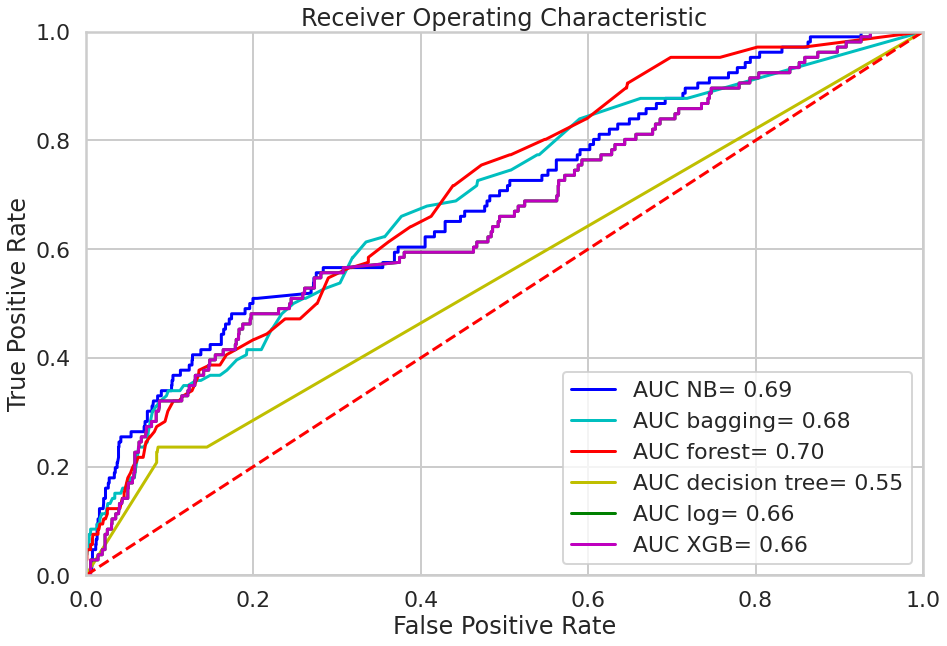

In [30]:
plt.figure(figsize=(15,10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_nb, tpr_nb, 'b', label = 'AUC NB= %0.2f' % roc_auc_nb)
plt.plot(fpr_bagging, tpr_bagging, 'b', label = 'AUC bagging= %0.2f' % roc_auc_bagging, color = 'c')
plt.plot(fpr_forest, tpr_forest, 'b', label = 'AUC forest= %0.2f' % roc_auc_forest, color = 'r')
plt.plot(fpr_tree, tpr_tree, 'b', label = 'AUC decision tree= %0.2f' % roc_auc_tree,color = 'y')
plt.plot(fpr_log, tpr_log, 'b', label = 'AUC log= %0.2f' % roc_auc_log, color = 'g')
plt.plot(fpr_model, tpr_model, 'b', label = 'AUC XGB= %0.2f' % roc_auc_model, color = 'm')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

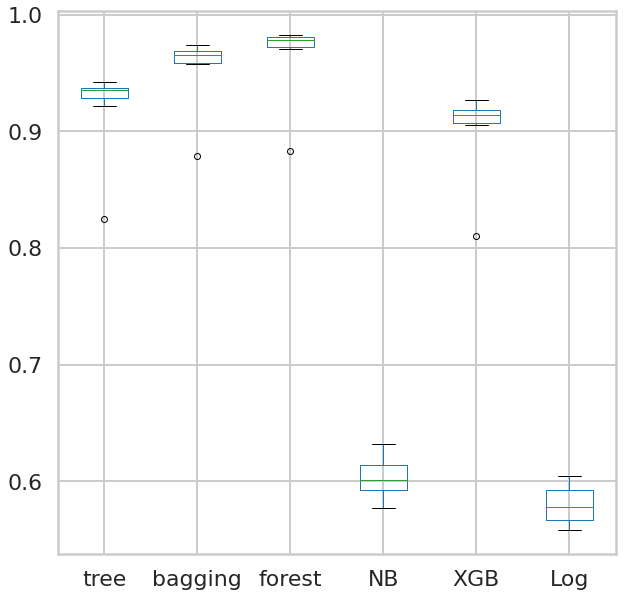

In [32]:
#Side by side comparison of all classification models using their cross validation scores
dfBox = pd.DataFrame(data = list(zip(score_tree, score_bagging, score_forest, NB_Cross, score_XGB, score_log)), columns = ['tree','bagging','forest','NB', 'XGB', "Log"])
dfBox.boxplot(figsize= (10,10))


Based on the AUC figure, Naive Bayes and Random Forest were among the best performing models. Taking into account multiple evaluation metrics (AUC, Confusion Matrix, Cross-Validation Score) our group decided to use random forest. Random Forest was consistently performing well in all evaluation metrics. Despite Naive Bayes's superior ability in predicting churn (as seen in its confusion matrix), it was eliminated from our consideration due to the fact that it has a poor performance in predicting non-churn customers accurately. 

QUESTION-5

In [33]:
#Predicted Probabilities for the Random Forest Classification Model
dfnew = pd.DataFrame(df.drop(columns = ["ID","Churn"]))
Predicted = pd.DataFrame(forest.predict_proba(dfnew))


In [41]:
#Joining the predicted probabilities data frame with the original data frame
dfnew1 = pd.concat([df,Predicted[1]],axis=1)
dfnew1.set_index("ID", inplace=True)
dfnew1.rename(columns={1:"Predicted Churn Probability"}, inplace=True)
dfnew1.head()   

,Age,Churn,CHI_0,CHI_1,Support_Cases_0,Support_Cases_1,SP_0,SP_1,Logins_1,Blogs_1,Views_1,Days_Last_Login,Predicted Churn Probability
ID,,,,,,,,,,,,,
1,67,0,0,0,0,0,0.0,0.0,0,0,0,31,0.00
2,67,0,62,4,0,0,0.0,0.0,0,0,-16,31,0.02
3,55,0,0,0,0,0,0.0,0.0,0,0,0,31,0.00
4,63,0,231,1,1,-1,3.0,0.0,167,-8,21996,0,0.03
5,57,0,43,-1,0,0,0.0,0.0,0,0,9,31,0.04


In [45]:
#Probabilities for the specified customer ID's 
cust_ids = [672, 354, 5203]
for i in cust_ids: 
  print("predicted probability of churning for customer ID", i ,"is",dfnew1.iloc[i-1,12])


predicted probability of churning for customer ID 672 is 0.16
predicted probability of churning for customer ID 354 is 0.08
predicted probability of churning for customer ID 5203 is 0.2


In [46]:
#Top 100 Customers with Highest Churn Probabilities 
pd.set_option("display.max_rows",None)
dfnew1.sort_values('Predicted Churn Probability',inplace=True, ascending=False)
dfnew1.head(100)


,Age,Churn,CHI_0,CHI_1,Support_Cases_0,Support_Cases_1,SP_0,SP_1,Logins_1,Blogs_1,Views_1,Days_Last_Login,Predicted Churn Probability
ID,,,,,,,,,,,,,
1679,16,1,73,16,0,0,0.000000,0.000000,0,0,-196,31,1.000000
2296,33,1,0,0,0,0,0.000000,0.000000,0,0,0,31,1.000000
402,12,1,8,-7,0,0,0.000000,0.000000,0,0,0,31,1.000000
948,15,1,0,0,0,0,0.000000,0.000000,0,0,-1,31,1.000000
1488,36,1,5,0,0,0,0.000000,0.000000,0,0,0,31,1.000000
3228,12,1,0,0,0,0,0.000000,0.000000,0,0,0,30,1.000000
2166,21,1,0,0,0,0,0.000000,0.000000,0,0,0,31,1.000000
227,13,1,0,0,0,0,0.000000,0.000000,0,0,-1,31,1.000000
979,13,1,0,0,0,0,0.000000,0.000000,0,0,-1,31,1.000000


Great Job!